In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [2]:
def get_dataset(file_path, lim_inf, lim_sup):
    '''
    Agafa el cataleg en parquet retorna un dataframe amb halos
    d'entre lim_inf (inclos) i lim_sup (no inclos) galaxies amb les columnes que ens interessen
    '''
    cat = pd.read_parquet(file_path) #obrir catàleg
    array_radis = np.sqrt((cat['x_gal'].to_numpy() - cat['x_halo'].to_numpy())** 2  #distància de les galàxies respecte del centre
                      + (cat['y_gal'].to_numpy() - cat['y_halo'].to_numpy()) ** 2
                      + (cat['z_gal'].to_numpy() - cat['z_halo'].to_numpy()) ** 2)
    cat['radis'] = pd.DataFrame(array_radis)
    array_x = cat['x_gal'].to_numpy() - cat['x_halo'].to_numpy() #posicions respecte del centre dels halos, per tenir dades més diferenciades per a millor anàlisi del model
    array_y = cat['y_gal'].to_numpy() - cat['y_halo'].to_numpy()
    array_z = cat['z_gal'].to_numpy() - cat['z_halo'].to_numpy()
    cat['x_in_halo'] = pd.DataFrame(array_x)
    cat['y_in_halo'] = pd.DataFrame(array_y)
    cat['z_in_halo'] = pd.DataFrame(array_z)

    cat = cat[['halo_id','x_in_halo', 'y_in_halo','z_in_halo', 'radis', 'abs_mag_r01','g01r01_hod','ax_halo', 'ay_halo', 'az_halo','b_to_a_halo','c_to_a_halo']]
    counts = cat['halo_id'].value_counts()


    counts = counts[counts >= lim_inf]
    halos_n_gal_series = counts[(counts < lim_sup)]

    halos_n_gal_series = list(halos_n_gal_series.index)

    cat2 = cat[cat['halo_id'].isin(halos_n_gal_series)]
    return cat2

def random_round(numero):
    num_int = int(numero)
    decimal = numero - num_int
    num_al = np.random.uniform()
    if num_al <= decimal:
        num_aprox = num_int + 1
    else:
        num_aprox = num_int
    return(num_aprox)

In [3]:
cat = get_dataset('/data/astro/scratch2/lcabayol/EUCLID/GHalo_FS/FS2_clusters_z04.parquet', 400,3000)
len(cat)/1e6

22.164579

In [4]:
# Llista de halos amb dades i labels
halo_id_values = np.unique(cat['halo_id'].to_numpy())
halo_id_values, len(halo_id_values)

llista_tensors = []
for halo_id in halo_id_values:
    llista_tensors.append(torch.tensor(cat[cat['halo_id'] == halo_id].to_numpy()))

len(llista_tensors)

24224

In [5]:
# Separo dades i labels; de labels agafo c i b to a
X_list=[]
y_list=[]
print(llista_tensors[0].shape)
for i in range(len(halo_id_values)):
    X_list.append(llista_tensors[i][:,1:-5])
    y_list.append(llista_tensors[i][:,-2:])
print(len(X_list), len(y_list), X_list[0].shape, y_list[0].shape, X_list[0].dtype, y_list[0].dtype)


torch.Size([1595, 12])
24224 24224 torch.Size([1595, 6]) torch.Size([1595, 2]) torch.float64 torch.float64


In [6]:
# Faig que només hi hagi una label per halo, no una per galàxia.
unique_y = []
for i in range(len(y_list)):
    unique_y.append(torch.unique(y_list[i]).squeeze())

In [7]:
# Tot el procés pot trigar molt, així que guardo passos intermitjos
torch.save(unique_y, 'unique_y_prov')
torch.save(X_list, 'X_list_prov')

In [8]:
unique_y = torch.load('unique_y_prov')
X_list = torch.load('X_list_prov')

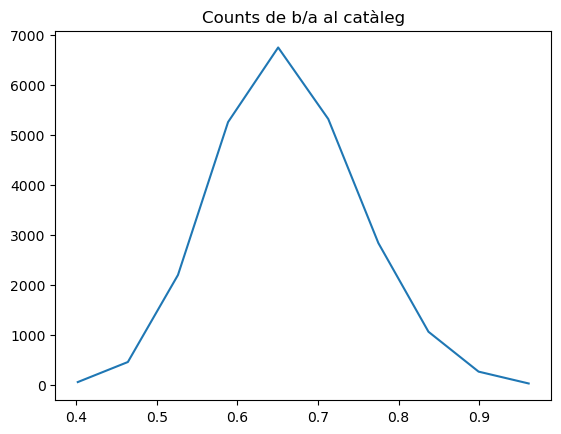

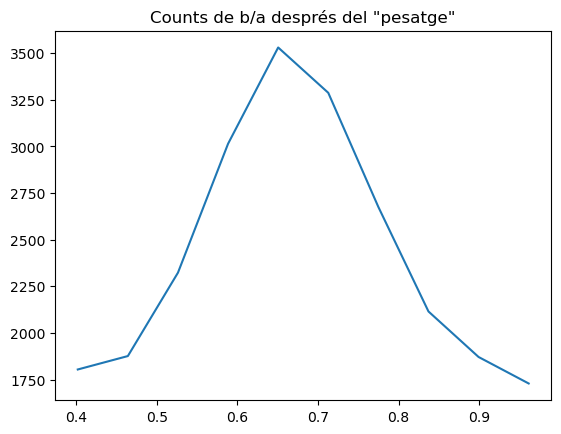

(torch.Size([24224, 2]), 24224, 45702, 24224, 45702)

In [9]:
# Aquí repeteixo els halos amb formes menys representades; els histogrames
# mostren la freqüència dels diferents b/a abans i després de fer-ho.

unique_y_tensor = torch.tensor(np.array(unique_y))
unique_y_tensor.shape

counts, bins = torch.histogram(unique_y_tensor[:,0], bins=10)
plt.plot(bins.numpy()[1:], counts.numpy())
plt.title('Counts de b/a al catàleg') 
plt.show()
moda = max(counts)

X_list_pes = X_list.copy()
unique_y_pes = list(unique_y_tensor)
for j in range(len(unique_y_tensor)):
    halo_shape = unique_y_tensor[j]
    halo_data = X_list[j]
    for i in range(len(counts)):
        if halo_shape[0] > bins[i] and halo_shape[0] < bins[i+1]:
            size= random_round(moda/(2*counts[i]) - 1/2)
            for k in range(size):
                insert_index =  np.random.randint(0,len(unique_y_pes))
                unique_y_pes.insert(insert_index, halo_shape)
                X_list_pes.insert(insert_index, halo_data)

unique_y_pes_tensor = unique_y_pes[0]
for i in range(1, len(unique_y)):
    unique_y_pes_tensor = torch.vstack((unique_y_pes_tensor, unique_y_pes[i]))


counts, bins = torch.histogram(unique_y_pes_tensor[:,0], bins=10)
plt.plot(bins.numpy()[1:], counts.numpy())
plt.title('Counts de b/a després del "pesatge"')
plt.show()
unique_y_pes_tensor.shape, len(unique_y), len(unique_y_pes), len(X_list), len(X_list_pes)

In [10]:
torch.save(unique_y_pes, 'unique_y_pes_prov')
torch.save(X_list_pes, 'X_list_pes_prov')

In [11]:
unique_y_pes = torch.load('unique_y_pes_prov')
X_list_pes = torch.load('X_list_pes_prov')

In [12]:
def make_batches(data, batch_size, delete_last):
    '''
    Converteix l'input (llista de tensors) en una llista de batches (llistes) de tensors
    '''
    output = []
    
    for i in range(0, len(data), batch_size):
        batch = data[i : i+batch_size]
        tensor_list = [torch.tensor(sample).to(torch.float32) for sample in batch]
        output.append(tensor_list)
    
    if delete_last:
        output = output[:-1]
    return output
    

def make_test_train_batched(data, train_fraction = 0.8, batch_size = 128, delete_last = True):
    '''
    Converteix l'input (llista de tensors) en dues (train i test) llistes de batches (llistes) de tensors 
    '''
    train_size = int(train_fraction * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    train_output = make_batches(train_data, batch_size, delete_last=delete_last)
    test_output = make_batches(test_data, batch_size, delete_last=delete_last)

    return train_output, test_output

In [13]:
# Faig batches
X_train, X_test = make_test_train_batched(X_list)
y_train_list, y_test_list = make_test_train_batched(unique_y)

X_train_pes, X_test_pes = make_test_train_batched(X_list_pes)
y_train_pes_list, y_test_pes_list = make_test_train_batched(unique_y_pes)

/tmp/ipykernel_471/57943903.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_list = [torch.tensor(sample).to(torch.float32) for sample in batch]


In [14]:
y_test = torch.tensor(np.array(y_test_list))
y_train = torch.tensor(np.array(y_train_list))
y_test_pes = torch.tensor(np.array(y_test_pes_list))
y_train_pes = torch.tensor(np.array(y_train_pes_list))
len(X_train), len(X_train[0]), X_train[0][0].shape, len(X_test), len(X_train_pes), len(X_test_pes), y_train.shape, y_test.shape, y_train_pes.shape, y_test_pes.shape

(151,
 128,
 torch.Size([1595, 6]),
 37,
 285,
 71,
 torch.Size([151, 128, 2]),
 torch.Size([37, 128, 2]),
 torch.Size([285, 128, 2]),
 torch.Size([71, 128, 2]))

In [15]:
torch.save(y_test, 'y_test_bctoa')
torch.save(y_train, 'y_train_bctoa')
torch.save(X_test, 'X_test_bctoa')
torch.save(X_train, 'X_train_bctoa')
torch.save(y_test_pes, 'y_test_pes_bctoa')
torch.save(y_train_pes, 'y_train_pes_bctoa')
torch.save(X_test_pes, 'X_test_pes_bctoa')
torch.save(X_train_pes, 'X_train_pes_bctoa')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [2]:
y_test = torch.load('y_test_bctoa')
y_train = torch.load('y_train_pes_bctoa')
X_test = torch.load('X_test_bctoa')
X_train = torch.load('X_train_pes_bctoa')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
def get_loss_acc(model, X, y, loss_fn, exigencia):
    model.eval()
    test_loss = 0
    if output_len > 1:
        acc = np.zeros(output_len)
    else:
        acc = 0
    with torch.inference_mode():
        for i in range(len(X)):
            output = model(X[i]).to(device)
            labels = y[i].to(device)
            test_loss += loss_fn(output, labels)
            encerts = 0
            if output_len > 1:
                for j in range(len(output)):  
                    rel_err = torch.abs(output[j]-labels[j])*100/labels[j] 
                    for k in range(output_len):    
                        if rel_err[k] < exigencia:
                            acc[k] += 1/len(output)
            else:
                for j in range(len(output)):  
                    rel_err = torch.abs(output[j]-labels[j])*100/labels[j] 
                    if rel_err < exigencia:
                        acc += 1/len(output)                

        test_loss /= len(X)
        acc *= 100/len(X) 
        print(f'Test loss: {test_loss: .5f}, Accuracy: {np.round(acc, 2)} %')
        return test_loss, acc

def train_step(model, X, y, loss_fn, opt, scheduler, use_scheduler, epoch, print_every):
    train_loss = 0
    model.train()
    
    for i in range(len(X)):
        opt.zero_grad()
        output = model(X[i]).to(device)
        

        loss = loss_fn(output, y[i].to(device))
        loss.backward()
        opt.step()

        train_loss += loss.item()

    train_loss /= len(X)
    if epoch % print_every == 0:
        print(f'Train loss: {train_loss:.5f}')
    if use_scheduler:
        scheduler.step(loss)


def test_step(model, X, y, loss_fn, epoch, print_every, epochs, exigencia):
    if epoch % print_every == 0:
        test_loss, acc = get_loss_acc(model, X, y, loss_fn, exigencia)
        print(np.round(epoch/epochs *100, 1), '%')

In [5]:
class Model(nn.Module):
    def __init__(self, input_len:int, output_len:int, batch_size:int):
        super().__init__()
                        
        self.lin_block = nn.Sequential(
                                nn.Linear(input_len, 256),
                                nn.ELU(),
                                nn.Linear(256, 256),                                
                            )
        self.lin_block2 = nn.Sequential(
                                nn.Linear(256, 256),
                                nn.ELU(),
                                nn.Linear(256, output_len),
                            )
        self.batch_size = batch_size
        self.input_len = input_len
        self.output_len = output_len



    def forward(self, data):
        x = [self.lin_block(x_elem.to(device)) for x_elem in data]
        xsum =[xx.sum(0) for xx in x]
        x = torch.stack(xsum)
        output = self.lin_block2(x)

        return output.squeeze()

In [6]:
torch.manual_seed(42)
input_len = 6
output_len = 2
model = Model(input_len=input_len, output_len=output_len, batch_size = 128).to(device)

In [7]:
model(X_test[0]).shape, y_test.shape, len(X_test)

(torch.Size([128, 2]), torch.Size([37, 128, 2]), 37)

In [8]:
lr = 1e-2 
mode = 'min'
factor = 0.2
patience = 300
threshold = 0.0001
threshold_mode = 'abs'

In [9]:
opt = torch.optim.Adagrad(model.parameters(), lr=lr)
loss_fn = nn.L1Loss()
#criterion = relative_squared_error
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode=mode, factor=factor, patience=patience, threshold=threshold, threshold_mode=threshold_mode)
save_file = 'mod2_adagrad_pes_2.pt'

In [10]:
# %%time
# epochs = 10000
# print_every = 10

# for epoch in range(epochs):
#     train_step(model=model, X=X_train, y=y_train, loss_fn=loss_fn, opt=opt,
#                 scheduler=scheduler, use_scheduler=False, epoch=epoch, print_every=print_every)
#     test_step(model=model, X=X_test, y=y_test, loss_fn=loss_fn, epoch=epoch,
#               print_every=print_every, epochs=epochs, exigencia=10)
#     if epoch % 100 == 0:
#         torch.save(model.state_dict(), save_file)

In [11]:
#torch.save(model.state_dict(), save_file)

In [12]:
model.load_state_dict(torch.load(save_file))


<All keys matched successfully>

In [13]:
print(model(X_test[0][:5]), '\n', y_test[0][:5])

tensor([[0.5943, 0.7367],
        [0.6853, 0.7992],
        [0.7511, 0.8616],
        [0.6377, 0.7742],
        [0.6939, 0.8308]], device='cuda:0', grad_fn=<SqueezeBackward0>) 
 tensor([[0.6661, 0.7250],
        [0.6635, 0.7850],
        [0.7720, 0.8839],
        [0.5754, 0.8786],
        [0.6396, 0.8549]])


r2 =  0.83


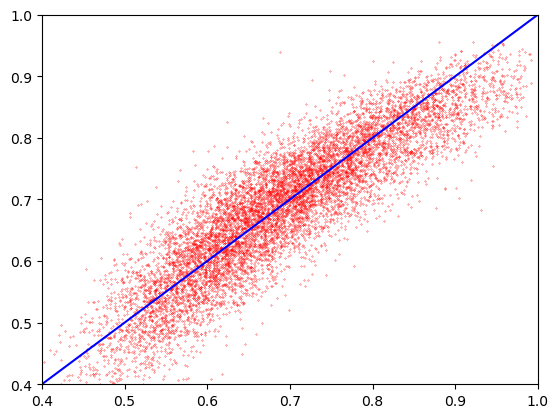

In [14]:
model.eval()
corr = 0
with torch.inference_mode():
    for i in range(len(X_test)):
        plt.plot(y_test[i].to('cpu').numpy(), model(X_test[i]).to('cpu').numpy(), '.', color = 'r', markersize = .5)
        corr += np.corrcoef(model(X_test[i])[:,1].to('cpu').numpy(), y_test[i][:,1].to('cpu').numpy())[0,1]
print('r2 = ', np.round(corr/len(X_test),2))
plt.plot(np.array([0.4,0.5,0.6,0.7,0.8,0.9,1]),np.array([0.4,0.5,0.6,0.7,0.8,0.9,1]), '-', color = 'b')

plt.xlim(0.4,1)
plt.ylim(0.4,1)
plt.show()



r2 =  0.82


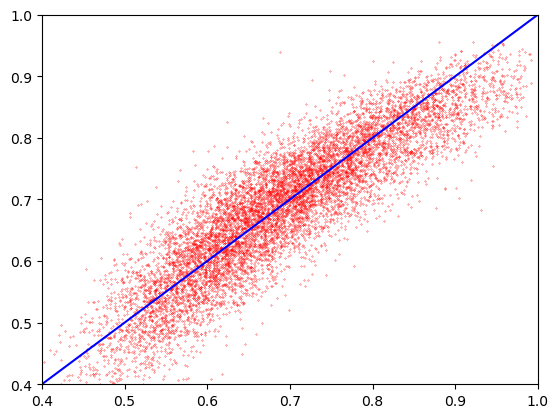

In [15]:
model.eval()
corr = 0
with torch.inference_mode():
    for i in range(len(X_test)):
        plt.plot(y_test[i].to('cpu').numpy(), model(X_test[i]).to('cpu').numpy(), '.', color = 'r', markersize = .5)
        corr += np.corrcoef(model(X_test[i])[:,0].to('cpu').numpy(), y_test[i][:,0].to('cpu').numpy())[0,1]
print('r2 = ', np.round(corr/len(X_test),2))
plt.plot(np.array([0.4,0.5,0.6,0.7,0.8,0.9,1]),np.array([0.4,0.5,0.6,0.7,0.8,0.9,1]), '-', color = 'b')

plt.xlim(0.4,1)
plt.ylim(0.4,1)
plt.show()

